In [1]:
#Libraries

#-------standar Libraries
import pandas as pd
import numpy as np
import operator #to sort dictionaries
import re #regular expressions

#----statistics
from scipy.stats import chi2_contingency

#----nlp-
import nltk
from nltk.metrics import distance #edit distance between words
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer


#------plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

#------ML
from sklearn.feature_selection import SelectKBest, chi2
from kmodes.kmodes import KModes #clustering cat data
from sklearn import preprocessing 
from sklearn.decomposition import PCA

#-----splitting
from sklearn.model_selection import train_test_split

#----Metrics
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import mean_absolute_error

#---ensembles
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost.sklearn import XGBClassifier
#-----basic classifiers
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB

# Raw Data

In [4]:
data.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889


In [7]:
#features
data.keys()

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

# Basic Plots

Let us consider the frequency plots for some of the atributes.

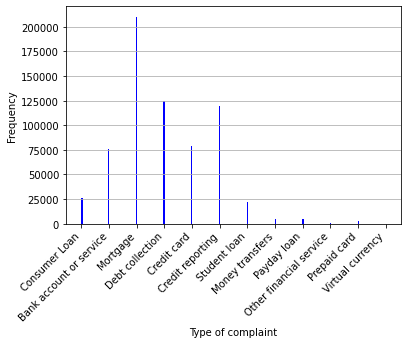

In [8]:
#Type of product/complain
plt.hist(x=data['Product'], bins='auto', color='b')
plt.grid(axis='y')
plt.xlabel('Type of complaint')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

We notice right away that the most common complain is related to Mortgages, secondly Debt Collection. While the loans (Students and Costumers) have few complaints, although they're not the lower bound, the least number of complains are the ones classified as virtual currency and other finantial services. 

On the other han in the most common kind of complains we have that they were submitted via web mostly, where Email is the least option, this can be infered as that clients to not usually want to write (say email) a complain, instead they prefered a more automatic service. 

In [10]:
dic={}
for tipo in np.unique(data['Product']):
    #print(data[data['Product']==tipo].shape[0])
    dic[tipo]=data[data['Product']==tipo].shape[0]
sorted(dic.items(), key=lambda x: x[1], reverse=True)

[('Mortgage', 210324),
 ('Debt collection', 124236),
 ('Credit reporting', 119195),
 ('Credit card', 79007),
 ('Bank account or service', 76084),
 ('Consumer Loan', 26604),
 ('Student loan', 21651),
 ('Payday loan', 4786),
 ('Money transfers', 4720),
 ('Prepaid card', 3171),
 ('Other financial service', 806),
 ('Virtual currency', 14)]

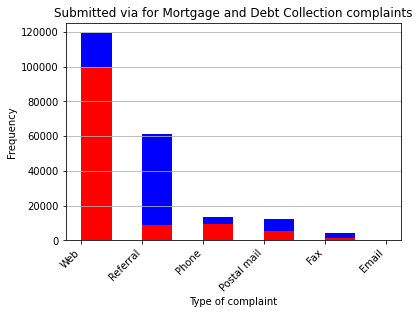

In [9]:
plt.hist(x=data[data['Product']=='Mortgage']['Submitted via'],  color='b')
plt.hist(x=data[data['Product']=='Debt collection']['Submitted via'],  color='r')
plt.grid(axis='y')
plt.title('Submitted via for Mortgage and Debt Collection complaints')
plt.xlabel('Type of complaint')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Now to see what they complaining about on the extreme categories, we notice that the issue variable is in fact categorial, we then have then:

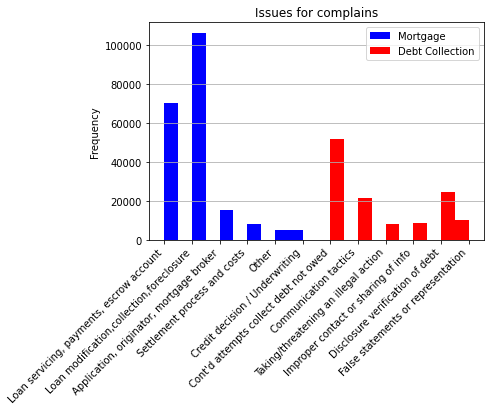

In [11]:
plt.hist(x=data[data['Product']=='Mortgage']['Issue'],  color='b', label='Mortgage')
plt.hist(x=data[data['Product']=='Debt collection']['Issue'],  color='r', label='Debt Collection')
plt.grid(axis='y')
plt.title('Issues for complains')
plt.legend()
#plt.xlabel('Issues reported')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

The main reason for complains is of Mortgage is Loan servicing, payments, escrow account; and Cont'd attempts collect debt not owed, respectively for Debt Collection. On the other hand, for the least ones their reason do overlap, saying they have not being more specified.

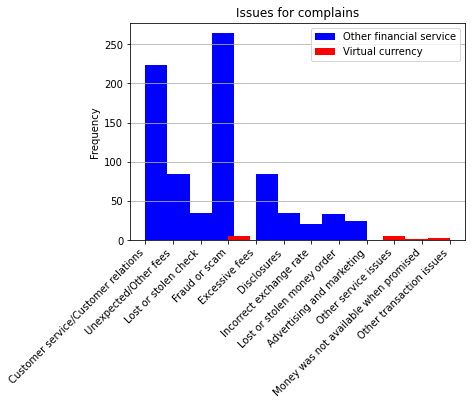

In [13]:
plt.hist(x=data[data['Product']=='Other financial service']['Issue'],  color='b', label='Other financial service')
plt.hist(x=data[data['Product']=='Virtual currency']['Issue'],  color='r', label='Virtual currency')
plt.grid(axis='y')
plt.title('Issues for complains')
plt.legend()
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

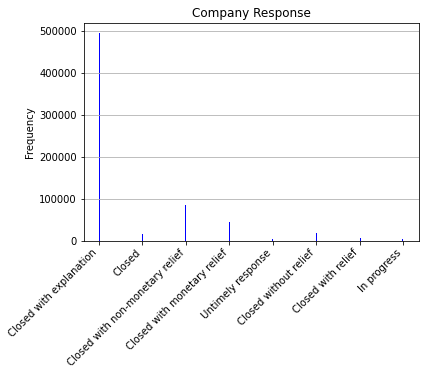

In [17]:
plt.hist(x=data['Company response to consumer'], bins='auto', color='b')
plt.grid(axis='y')
plt.title('Company Response')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

We have that the complains have been mostly closed with explanation, and the relief did not require to be monetary in most of the cases. Moreover, clients did not dispute.

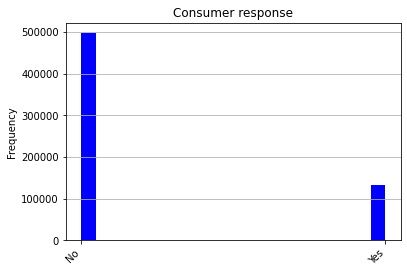

In [22]:
plt.hist(x=data[data['Consumer disputed?'].notnull()]['Consumer disputed?'], bins='auto', color='b')
plt.grid(axis='y')
plt.title('Consumer response')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Since we have the zip codes we could plot their location on a map. However they are not given correctly, notice than besides having nans, they are somehow censored.

In [30]:
data[data['ZIP code'].notnull()]['ZIP code']

0         24540
1         95992
2         10065
3         30084
4         06106
          ...  
670593    895XX
670594    847XX
670595    37174
670596    322XX
670597    39301
Name: ZIP code, Length: 665274, dtype: object

## Time plots

In [31]:
#The following code is to transform the date string given for a more suitble date format to work with,
data['Date received'] = pd.to_datetime(data['Date received'])

We have daily reports within 5 years, instead of ploting the change in time by day, we decided to show it yearly and montly. We have that at the end of year 2015 the number of complains decreased, however between 2013 and 2014 was the highest slope in the graph. It woul be interesting to see if they happend to be accumulative.

In [33]:
year=np.unique(data['Date received'].map(lambda x: x.year))
num_comp=data.groupby(data['Date received'].map(lambda x: x.year)).size()

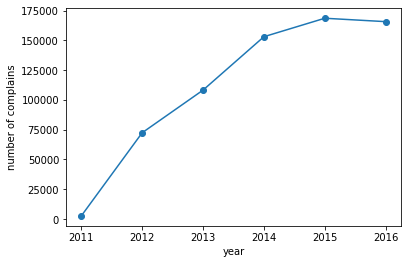

In [34]:
plt.plot(year, num_comp, marker='o')
plt.xlabel('year')
plt.ylabel('number of complains')
plt.show()

In [35]:
month=np.unique(data['Date received'].map(lambda x: x.month))
num_comp_m=data.groupby(data['Date received'].map(lambda x: x.month)).size()

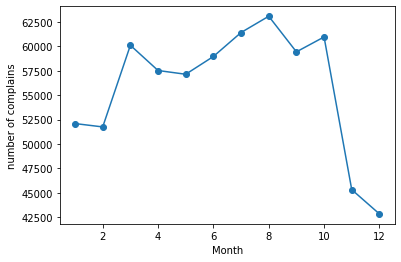

In [36]:
plt.plot(month,num_comp_m, marker='o')
plt.xlabel('Month')
plt.ylabel('number of complains')
plt.show()

But looking at the montly graph we'll see that right after agust a spike in the graph, meaning most of the complans were filed right after vacations, this might be realated to the begining of school year. 


Now we would like to study the relation between the type of complain and the company itself. To see thei dependecy we created a contingency table and a statistic test to see if there exist evident of independency between them.

In [37]:
CrosstabResult=pd.crosstab(data['Product'], data['Company'])

In [38]:
#Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
print('p value:', ChiSqResult[1])

p value: 0.0


So there exist evidence they are independent.

Lets now consider the relationship with the reported state. Here the first place belongs to California, and the last to Georgia (GA). We now compare the type of complain, now if we plot the type of complains for each of the top 5 states, we have a clearly pattern in CA, where they have the highest number of complains of each type/product. Also the Mortgage is the main reason over the top 5.

<BarContainer object of 5 artists>

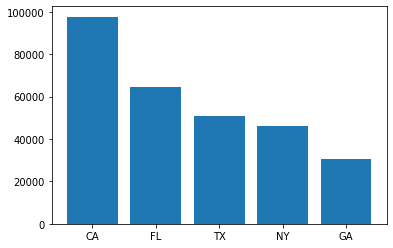

In [42]:
df=data.groupby(data['State']).size()
df=pd.DataFrame(data=list(zip(df.keys(), df)))
top_states=df.sort_values(by=1,ascending=False)[:5]
plt.bar(top_states[0], top_states[1])

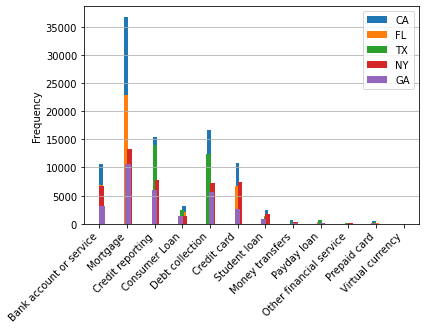

In [46]:
for state in list(top_states[0]):
    plt.hist(data[data["State"]==state]['Product'],bins='auto',label=state)
plt.grid(axis='y')
plt.legend()
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Now if we look at the number of complains in the top 5 of companies we have tha the Bank of America wins.

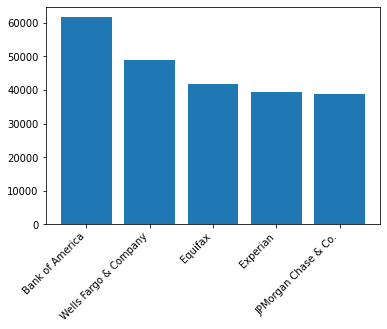

In [47]:
df_aux=data.groupby(data['Company']).size()
df_aux=pd.DataFrame(data=list(zip(df_aux.keys(), df_aux)))
top_comp=df_aux.sort_values(by=1,ascending=False)[:5]
plt.bar(top_comp[0], top_comp[1])
plt.xticks(rotation=45, ha='right')
plt.show()

In [49]:
def plot_time(df,time_interval,title):
    if time_interval=='year':
        x_var=list(np.unique(df['Date received'].map(lambda x: x.year))) #variable
        y_var=list(df.groupby(df['Date received'].map(lambda x: x.year)).size()) #frequency of variable
    else:
        x_var=list(np.unique(df['Date received'].map(lambda x: x.month))) #variable
        y_var=df.groupby(df['Date received'].map(lambda x: x.month)).size() #frequency of variable

    plt.scatter(x_var,y_var,label=title)
    plt.xlabel(time_interval)
    plt.ylabel('number of complains')

We now plot the number of complains in such company for the top 5 yearly, we have that BoA had a rough time in 2012 to 2013 having most of the complains, but in 2016 it stands out as one with the least number, then Equifax clearly shows a pattern of increasing. However if we look at it montly we have that still BoA wins them all through all the months.

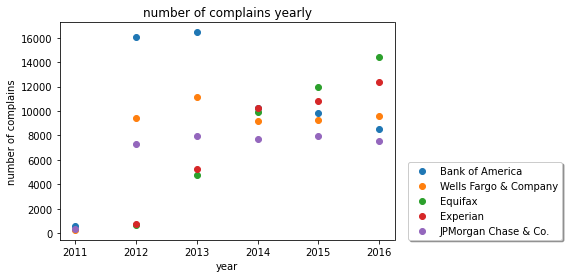

In [52]:
for company in list(top_comp[0]):
    plot_time(data[data["Company"]==company],'year',company)
plt.title('number of complains yearly')
plt.legend(loc=(1.04, 0), shadow=True)
plt.show()

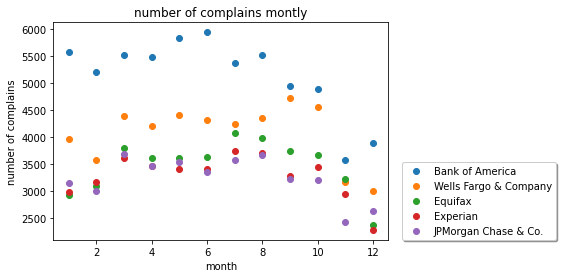

In [51]:
for company in list(top_comp[0]):
    plot_time(data[data["Company"]==company],'month',company)
plt.title('number of complains montly')
plt.legend(loc=(1.04, 0), shadow=True)
plt.show()

***

# Text Normalization of Companies Names

First let us normalize to some extent the name of companies

In [53]:
data['Company']=data['Company'].map(lambda x: x.strip() and x.lower()) #case folding and triming spaces at both extremes

In [54]:
bancos=list(set(data['Company']))

In [55]:
bancos.sort() #we sort them out so that we have a more smooth search 

Now we search fo all the names of companies that have a strong evidence that they refer to the same thing. We found that most of them had simple errors, see below.

In [56]:
dic={}
for i in range(len(bancos)):
    bench = bancos[i]
    similar=[]
    for j,b in enumerate(bancos[i+1: i+40]):
        if distance.edit_distance(bench, b, substitution_cost=1, transpositions=True) < 2:
            print(j, bench, " ---objetivo--- ", b, flush=True)
            similar.append(b)
            dic[b]=bench

0 bay valley mortgage group  ---objetivo---  bay-valley mortgage group
1 collection service, inc.  ---objetivo---  collection services, inc.
0 credit adjustment, inc  ---objetivo---  credit adjustments inc
0 elite financial services, inc  ---objetivo---  elite financial services, inc.
26 gcfs, inc.  ---objetivo---  gfs, inc.
0 professional collection service inc  ---objetivo---  professional collection service, inc


In [57]:
# Homogenize all the names
data['Company']=data['Company'].replace(dic)

In [58]:
#Example
data[data['Company']=='bay-valley mortgage group']

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID


***

# Text Analysis

The next function creates the wordcloud w/o considering stopwords.

In [60]:
def get_cloud(text,title):
    stwords = set(nltk.corpus.stopwords.words('spanish'))
    word_cloud = WordCloud(width=4000,
                           height=4000,
                           colormap='PuRd',
                           margin=0,
                           max_words=100, 
                           stopwords=stwords,
                           background_color="white").generate(text)


    plt.figure(figsize=(12, 12))
    plt.imshow(word_cloud, interpolation='gaussian')
    plt.axis("off")
    plt.title(title)
    plt.show()

In [61]:
df_aux=data[data['Company']=='bank of america']
text=list(df_aux[df_aux['Consumer complaint narrative'].notnull()]['Consumer complaint narrative'])
text_string=' '.join(text)

In order to get some information about the complains recieved in the Bank of America, we did feature selection by means of information gain and findind also the most common words with nlp tools in the library nltk.

In [62]:
words = nltk.tokenize.word_tokenize(text_string)
words= [wrd.strip() for wrd in words ]

In [63]:
words= [wrd.lower() for wrd in words ]

In [64]:
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['.','xxxx','i','44728','','*','.',',','$','{','}', 'xx','x','?','¿']) #Remove some special characters
allWordExceptStopDist = nltk.FreqDist(w for w in words if w not in stopwords)

In [65]:
top_common_words=list(allWordExceptStopDist.keys())

In [66]:
top_common_words_text=' '.join(top_common_words[:1000])
len(top_common_words_text)

7625

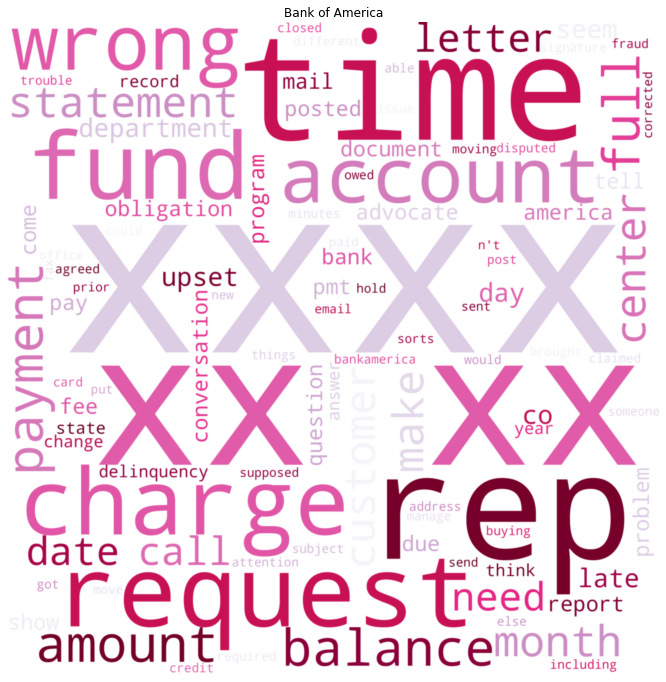

In [67]:
get_cloud(top_common_words_text,'Bank of America')

Assuming the censored data is the most common word used in their complains, we can distinguish some other interesting, as charge, time and balance. Meaning that most complains might be about some payments, problems with their account or some unknown charges to say the least. Of course, this plot might be better explained by someone with experience in the field.


Now let us gain more information about these complains, and getting the word most related to the type of product (or complain), the next code gets such feature.

In [68]:
keys=list(df_aux[df_aux['Consumer complaint narrative'].notnull()]['Product'].unique())

In [69]:
cv = CountVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
X_vec = cv.fit_transform(text)

In [70]:
Y=df_aux[df_aux['Consumer complaint narrative'].notnull()]['Product'].map(dict(zip(keys,np.arange(len(keys)))))

In [71]:
res = dict(zip(cv.get_feature_names_out(), mutual_info_classif(X_vec, Y, discrete_features=True)))

In [72]:
dictionary = sorted(res.items(), key=operator.itemgetter(1), reverse=True)

In [73]:
words_new=[ x for x,y in dictionary]

In [74]:
word_new_text=' '.join(words_new)

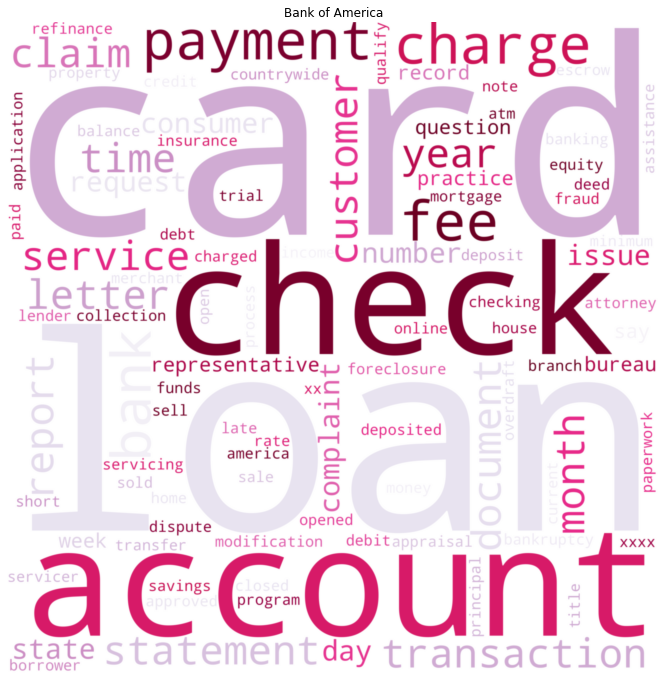

In [75]:
get_cloud(word_new_text,'Bank of America')

In this new word cloud we have more interesting words, refering to loans, cards, account and payment so that complains of this bank are most related to these questions, recall that these new corpora is stronly related to the type of complain (or product).

We finally consider a naive approach with this new information, let us take the complains of the Bank of America, knowing that this bank got most of the complains reported. And considering the corpora above with information gain, let us filter out each client's narrative with these words, so that we consider only these in each complain.

First we consider the following function that filters out the complain with respect to the found corpora.

In [76]:
def new_complain(complain, words):
    new_compl=[words[0]]
    for word in complain.split(' '): 
        if word in words and word not in new_compl:
            new_compl.append(word)
    return ' '.join(new_compl)

def clean(complain):
    clean_text=re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,$]", "", complain ) #Remove special characters
    return re.sub(r"\s*xxxx",'',clean_text) #remove the censored data xxxx

In [77]:
#Consider only the observations that do have a captured text complain narrative
df_aux=data[data['Consumer complaint narrative'].notnull()][['Consumer complaint narrative','Product']]

We have then reduced the data to work with to 114704 observations.

In [79]:
df_aux.shape[0]

114704

In [80]:
#Normalize text
df_aux['Consumer complaint narrative']=df_aux['Consumer complaint narrative'].map(lambda x: x.lower())

Example

In [81]:
list(df_aux['Consumer complaint narrative'])[0]

'received capital one charge card offer xxxx. applied, was accepted ( {$500.00} limit ), activated card and used for xxxx presents. charge card # xxxx. right after activating card ... capital one sent me another card with same {$500.00} limit ... never activated ... never used that card. first bill from above card # came due xxxx and minimum payment due was {$15.00}. i sent in {$20.00} via uspmo and sent in before due date. with the xxxx non-activated, non used credit card ... ..they also sent me bill for some yearly fees when never even activated the card. so called them up ... ... .told them did not want the card and sent back to them. well ... .get my next bill from the card # above ( xxxx ) ... .they did not credit me for the {$20.00} payment and charged me outrageous over the limit fees, late fees, etc ... and now {$70.00} payment due. so, i called up, their rep stated they accidentally applied my {$20.00} payment to wrong account number and would be corrected. so, i sent in a {$7

In [82]:
new_complain(list(df_aux['Consumer complaint narrative'])[0],words_new)

'loan received charge card offer used xxxx right sent came minimum payment credit fees called did want charged late rep stated applied wrong account number note make sure payments correct wanted bankruptcy mail apply previous thought total numerous times mistake time kept calling resolution like paying point know end started getting phone calls collection agency really entire come bank currently knew took court illegal new receive clearly shows different practices regarding just recently home stating property address owner days look attorney need help'

Let us say here that we wanted to classify the type of product using the complains filtered with the above code,  we did not include the experiments here because of the limitations of this computer the use clusters were neede. The results weren't good enough to report them, but we conjecture that such idea can be properly put into practice with a more careful treatment of the text complains, we considered a BOW (bag of words) approach with MLP, XGBoost and Gaussian Processes since they are the state-of-the-art clasifiers in ML, and this approach was the easiest to try, however it is left open to use transformers or more deep learning techniques to improve the performance. We got a f1 score of 50%. 

# Clustering

For this unsupervised technique we make use of the most representative atributes from the given data. Again the target is the type of product.

We choose the following variables, we consider them to be more representative of the current problem. This is also a consequence of the statistics given at the begining.

In [83]:
data_clus=data[['Issue','Submitted via','Company response to consumer','Consumer disputed?','Product']]

At the begining we do not consider the companies since we conjecture they have to be analyse in depth.

In [84]:
#Remove the null rows
data_clus=data_clus[data_clus.notnull()]

In [85]:
data_clus[data_clus['Consumer disputed?'].isnull()]

,Issue,Submitted via,Company response to consumer,Consumer disputed?,Product
13,Communication tactics,Phone,Closed with explanation,NaN,Debt collection
35,"Loan modification,collection,foreclosure",Fax,Closed with explanation,NaN,Mortgage
156,Cont'd attempts collect debt not owed,Postal mail,Closed,NaN,Debt collection
191,Settlement process and costs,Referral,Closed with explanation,NaN,Mortgage
540,Taking/threatening an illegal action,Web,Closed with explanation,NaN,Debt collection
...,...,...,...,...,...
670589,Cont'd attempts collect debt not owed,Web,Closed with explanation,NaN,Debt collection
670591,Incorrect information on credit report,Web,Closed with non-monetary relief,NaN,Credit reporting
670592,"Loan modification,collection,foreclosure",Referral,In progress,NaN,Mortgage
670593,Incorrect information on credit report,Web,In progress,NaN,Credit reporting


Since the column 'Consumer disputed?' contains nans we consider them as a new category 'np' for not reported. We then discretize each column tagging each category as a numerical value as follows:

In [86]:
def set_category(column):
    dic={}
    i=0
    for cat in list(column.unique()):
        dic[cat]=i
        i=i+1
    return dic

In [87]:
data_clus['Issue']=data_clus['Issue'].replace(set_category(data_clus['Issue']))

In [88]:
data_clus['Product']=data_clus['Product'].replace(set_category(data_clus['Product']))

In [89]:
data_clus['Submitted via']=data_clus['Submitted via'].replace(set_category(data_clus['Submitted via']))

In [90]:
data_clus['Company response to consumer']=data_clus['Company response to consumer'].replace(set_category(data_clus['Company response to consumer']))

In [91]:
data_clus['Consumer disputed?']=data_clus['Consumer disputed?'].replace({'Yes':int(0), 'No':int(1), np.nan : int(2)})

In [92]:
data_clus.rename(columns={'Product':'target'},inplace=True)

In [93]:
data_clus

,Issue,Submitted via,Company response to consumer,Consumer disputed?,target
0,0,0,0,1.0,0
1,1,1,0,1.0,1
2,2,2,1,1.0,1
3,3,1,0,1.0,1
4,4,1,0,1.0,2
...,...,...,...,...,...
670593,12,1,7,2.0,5
670594,7,1,0,0.0,2
670595,12,1,0,0.0,5
670596,22,1,0,2.0,4


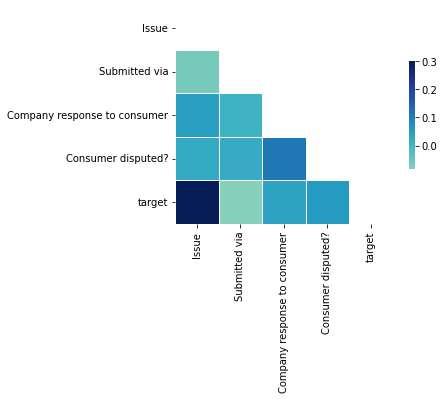

In [94]:
#Correlation Map
corr = data_clus.corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmax=.30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

With this correlation heat map, where Spearmen correlation coefficient was used (better for ordinal data), we notice the target variable (product) is strongly correlated to whether the consumer disputed and the response of the company, which is somehow of what we expected, the means of the complain is of not much use in this case, but we will keep hoping in future study this might be of use.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1599729.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 80653, cost: 1393630.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 79788, cost: 1244689.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 76535, cost: 1187349.0


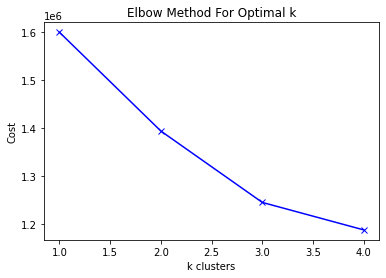

In [95]:
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(data_clus)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [100]:
km = KModes(n_clusters=3, init = "Cao", n_init = 1, verbose=1)
cluster_labels = km.fit_predict(data_clus)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1244689.0


In [101]:
#add cluster value to each observation
data_clus['cluster']=cluster_labels 

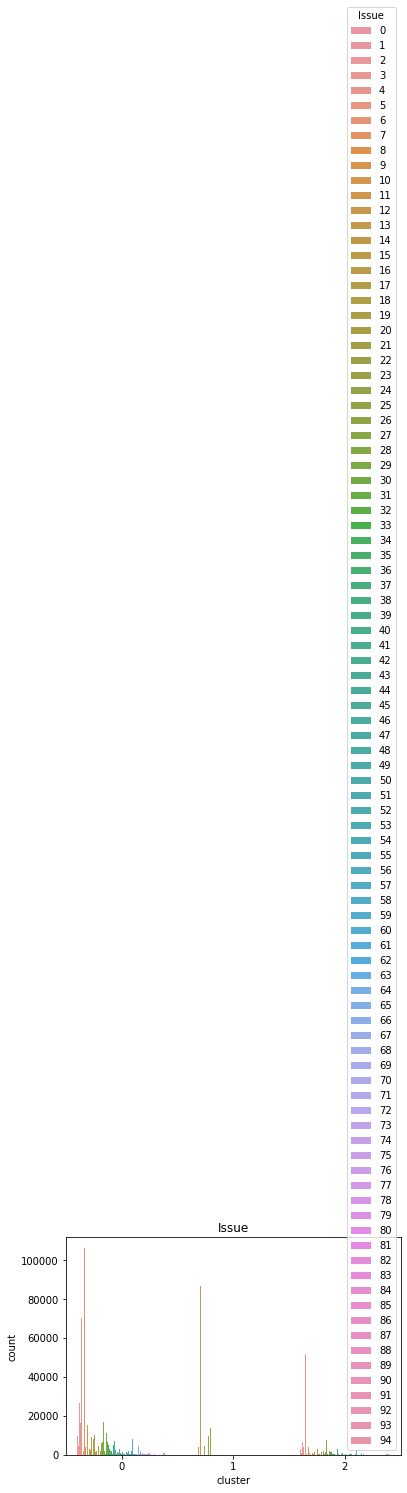

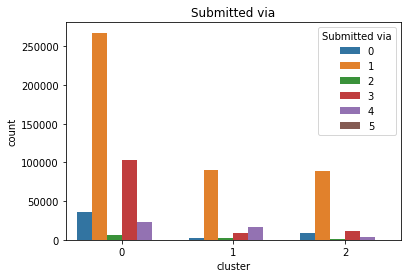

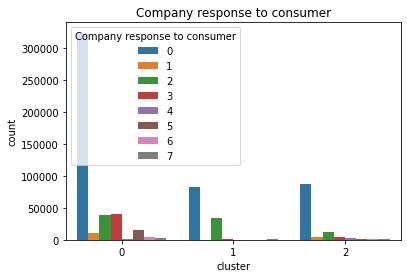

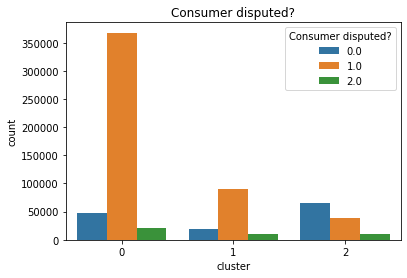

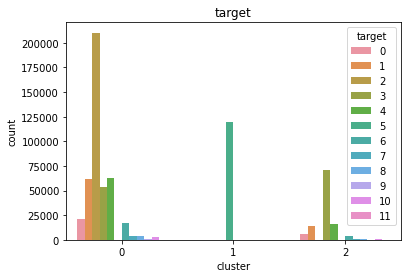

In [102]:
for col in ['Issue', 'Submitted via', 'Company response to consumer','Consumer disputed?', 'target']:
    sns.countplot(x='cluster',hue=col, data = data_clus)
    plt.title(col)
    plt.show()

For the plot above we have that, in the first the target variable has quite a number of categories and so their interpretation can be refined if we refined such categorization. The same would have happened if we reduce the study to a particular bank, for example in the bank of america we still have al the categories present. 


However, in the company response most of the responses are clustered in one, but we have the present of 0 and 2, which correspond to closed issued either with explanation or a non-monetary relief, and finally in the third behaves like the second, we could guess that data is somehow splited into either closed with relief or not. 


Finally in the type of complain (or product) we have a clear clustering of the student loan (cluster 1), and Mortgage and credit card (2 and 4) in the first cluster, and finally the third we have debt colletion.  Which they appeared before in the histograms. 


This might be improved with more clusters or with a more cured data treatment, to reduce the number of categories into a much more interpretable result, one could use in fact this results, as creating tree clear variables for the product: Student Loan, Mortgage (and some related issues) and finally debt collection.

Let us redefine the target with these new categories found in the clusters.

In [103]:
data_clus['target']=data_clus['target'].replace({1:0, 2:0, 4:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0})
data_clus['target']=data_clus['target'].replace({3:1, 5:2})

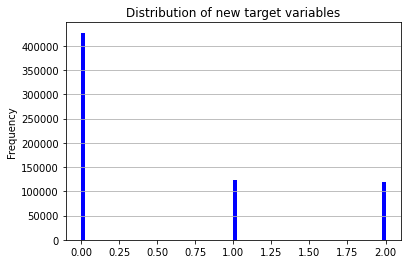

In [105]:
plt.hist(x=data_clus['target'], bins='auto', color='b')
plt.grid(axis='y')
plt.title('Distribution of new target variables')
plt.ylabel('Frequency')
plt.show()

Notice this resembles the clustering we got. We no turn to the problem of classification, where we want to classify the type of product in terms of the atributes above, again the data set we are considering is. 

# Classification problem


In this case we consider ensembles and Gaussian Processes, the main reason is because these models have showed great performance when dealing with ordinal data, see [1]


1. Cheng, J., Wang, Z., & Pollastri, G. (2008, June). A neural network approach to ordinal regression. In 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence) (pp. 1279-1284). IEEE.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data_clus.iloc[:, data_clus.columns != 'target'],data_clus['target'], test_size=0.3)

In [107]:
#XGBoost
model = XGBClassifier(random_state=2)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=2, reg_alpha=0, ...)

In [108]:
y_pred=model.predict(X_test)
_,_,fbeta_score,_=precision_recall_fscore_support(y_test, y_pred, average='weighted',zero_division=0)
print(fbeta_score)
print(mean_absolute_error(y_test, y_pred))

1.0
0.0


In [109]:
#AdaBoost
model = AdaBoostClassifier(random_state=2)
model.fit(X_train,y_train)

AdaBoostClassifier(random_state=2)

In [110]:
y_pred=model.predict(X_test)
_,_,fbeta_score,_=precision_recall_fscore_support(y_test, y_pred, average='weighted',zero_division=0)
print(fbeta_score)
print(mean_absolute_error(y_test, y_pred))

0.8544428057504345
0.14322497266129833


We then notice that when using esembles we have a really good accuracy, although this might seem as doing more than necessary, for the sake of simplicity, we also consider Naive Bayes classifier, but we could not get the same accuracy as before. 

In [112]:
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [114]:
y_pred=model.predict(X_test)
_,_,fbeta_score,_=precision_recall_fscore_support(y_test, y_pred, average='weighted',zero_division=0)
print(fbeta_score)
print(mean_absolute_error(y_test, y_pred))

0.8615643529169726
0.13331345064121683


We do not report the classification using all 12 categories because we consider that having less categories have more meaning, than the actual 12. Actually the classifiers did good (with a MAE of 0.03) with the 12th with both ensembles. As a side note, we could not use Gaussian Processes as a limitation of memory..